In [55]:
import bamt.preprocessors
import bamt.networks as Nets
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from itertools import product
from pgmpy.estimators import  K2Score
import numpy as np
import seaborn as sns

from experiments.experiments3.auxiliary.auxiliary import construct_by_quantiles, construct_by_kmeans, construct_by_uniform
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork

import copy

imagespath = 'C:/Users/Acer/PycharmProjects/BAMTclone/BAMT/experiments2/images'

SEED = 42

Sex / nominal / -- / M, F, and I (infant)
Length / continuous / mm / Longest shell measurement
Diameter / continuous / mm / perpendicular to length
Height / continuous / mm / with meat in shell
Whole weight / continuous / grams / whole abalone
Shucked weight / continuous / grams / weight of meat
Viscera weight / continuous / grams / gut weight (after bleeding)
Shell weight / continuous / grams / after being dried
Rings / integer / -- / +1.5 gives the age in years

In [2]:
data = pd.read_csv("../../datasets/abalone.data", sep=',', names=['sex', 'length', 'diameter', 'height', 'W_weight', 'S_weight', 'viscera_weight', 'shell_weight', 'rings'])
data.head(10)

,sex,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


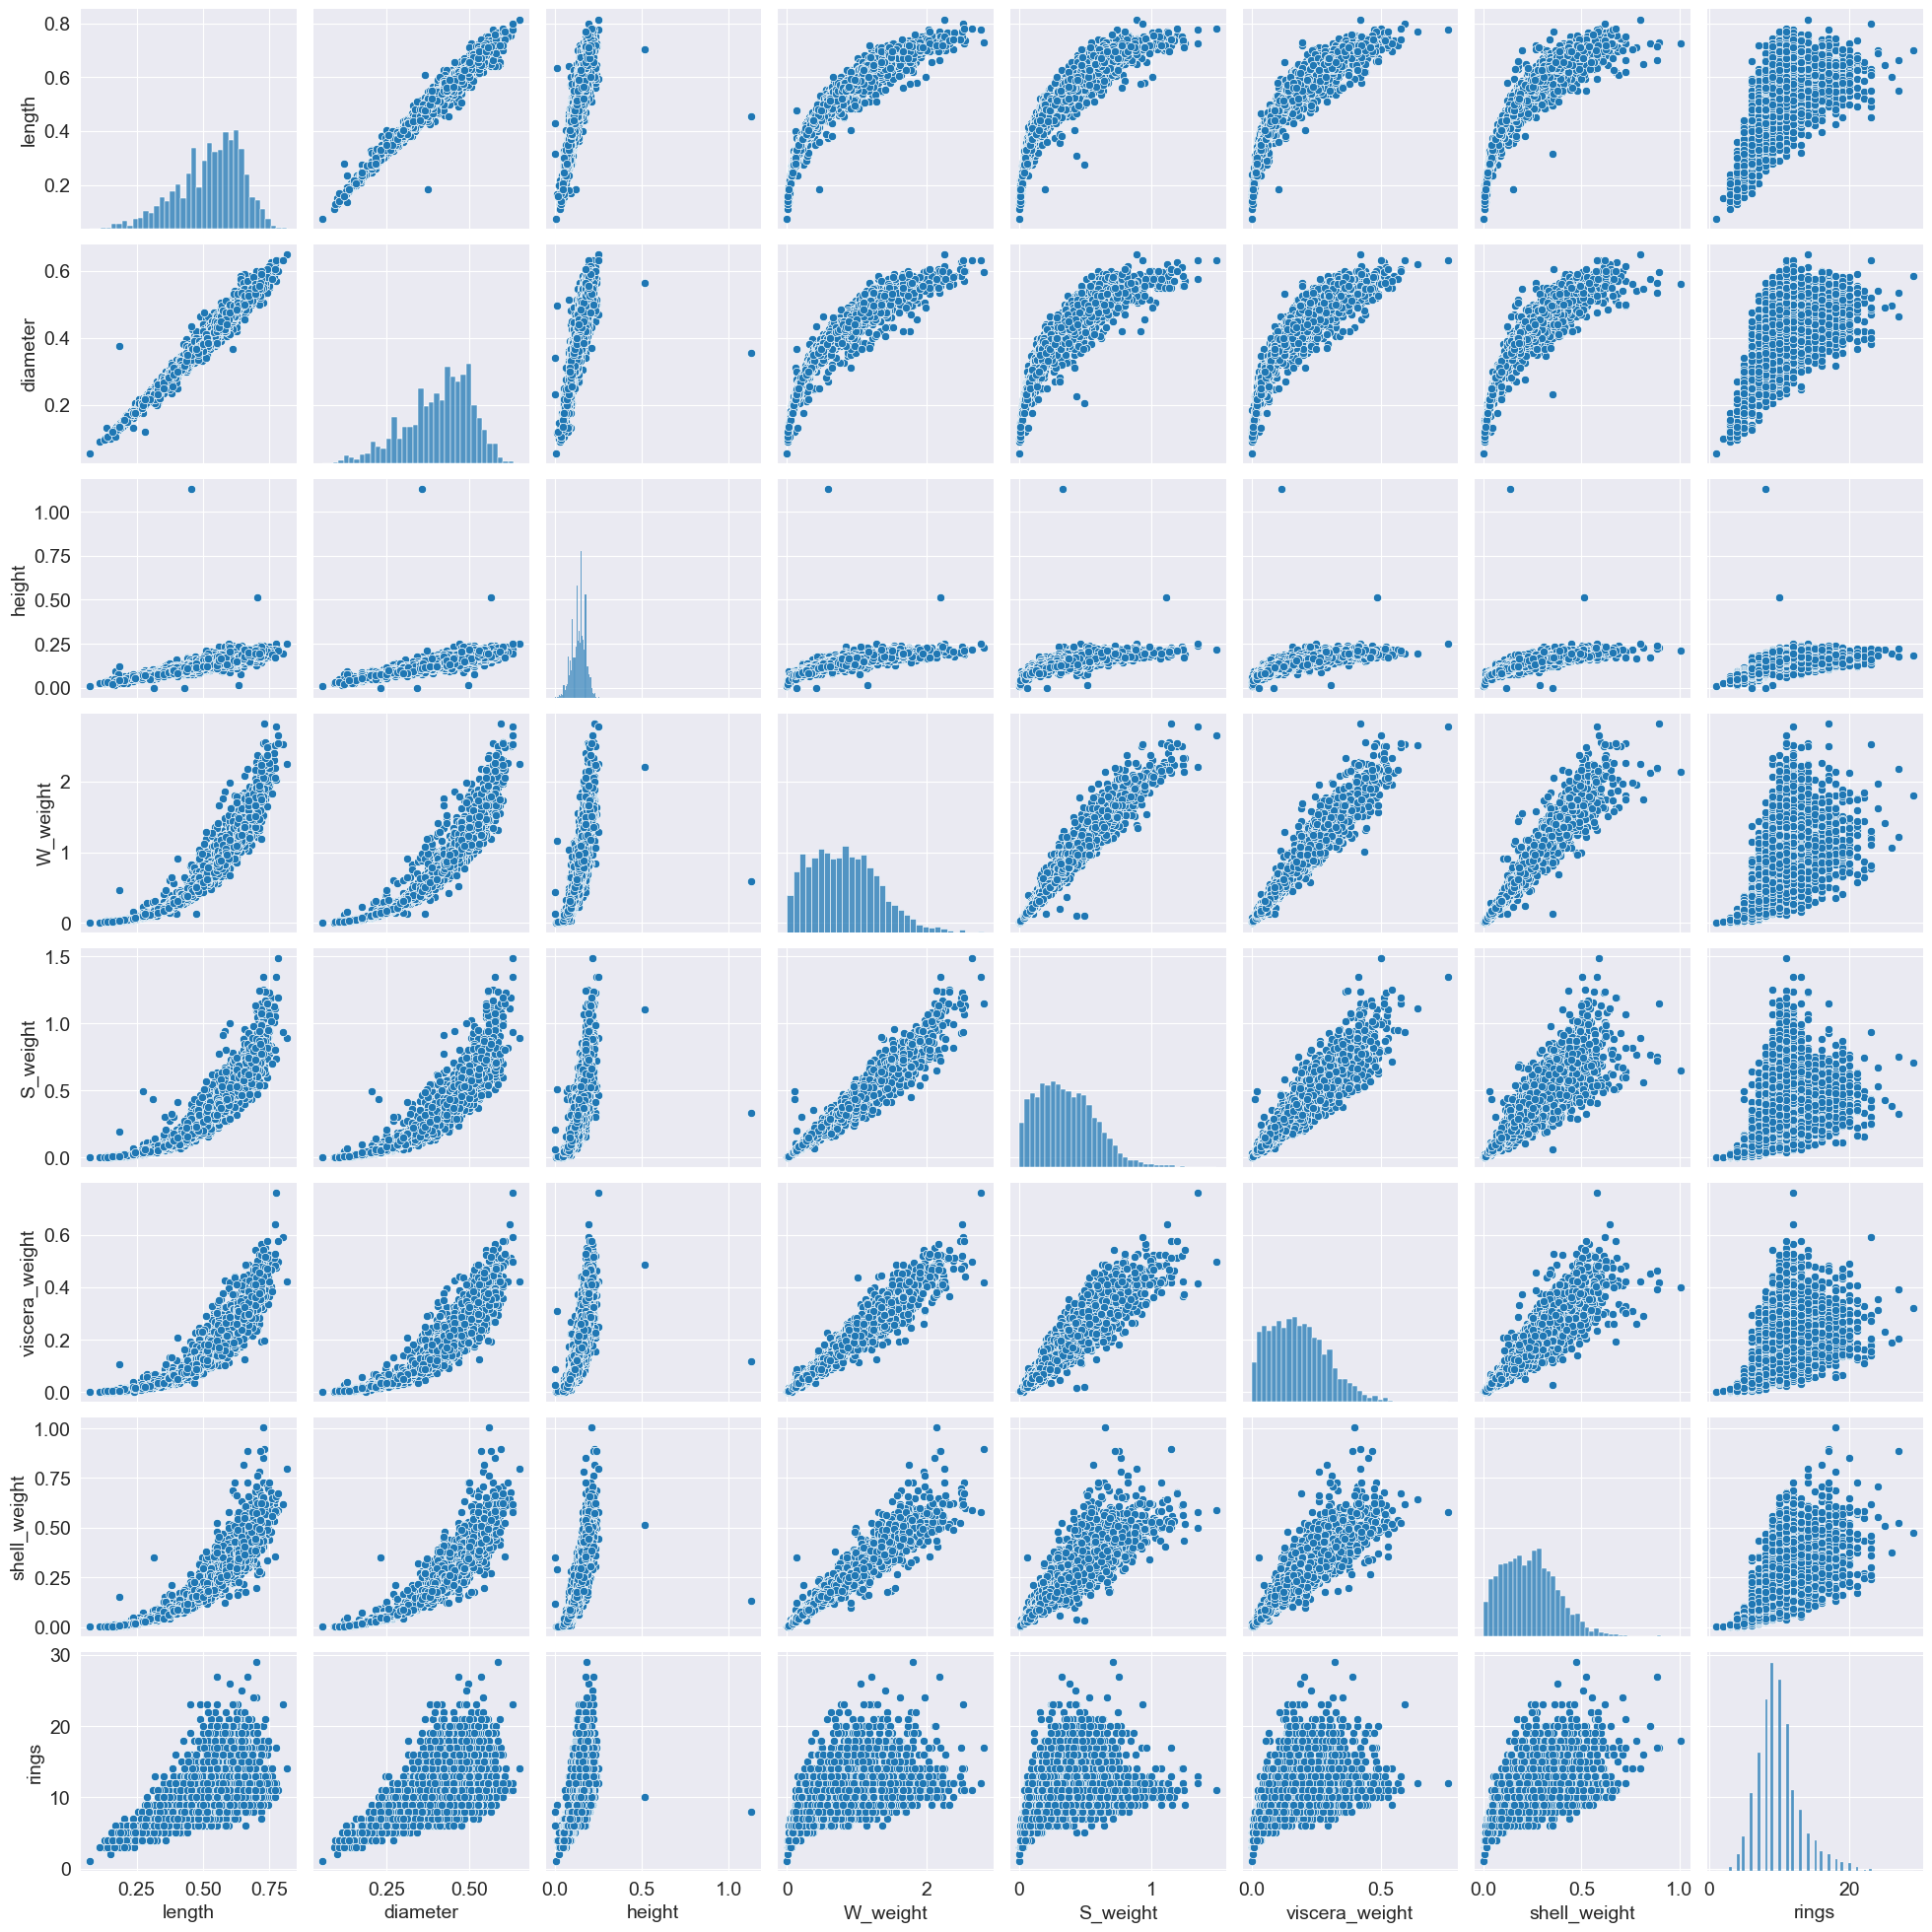

In [3]:
sns.pairplot(data.iloc[:, 1:])

In [4]:
data.shape

(4177, 9)

In [5]:
data['sex'] = data['sex'].map({'F': 0, 'M': 1, 'I': 2})

In [6]:
data

,sex,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,1,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,1,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [7]:
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import make_pipeline, make_union

In [8]:
icat = [0]
icont = list(range(1, 9))

kmeanspipeline = make_pipeline(make_union(
    make_pipeline(FunctionTransformer(lambda x: x[:, icat])),
    make_pipeline(FunctionTransformer(lambda x: x[:, icont]), KBinsDiscretizer(n_bins=3, encode="ordinal", random_state=42, strategy="kmeans"))
),
    FunctionTransformer(lambda x: x.astype("int")))

disc_data = pd.DataFrame(kmeanspipeline.fit_transform(data.values), columns=data.columns)

In [9]:
bn = Nets.DiscreteBN()

descriptor = {"types": {col: "disc" for col in disc_data.columns},
                           "signs": {}}

bn.add_nodes(descriptor)
bn.add_edges(disc_data, scoring_function=("K2", K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [10]:
bn.fit_parameters(disc_data)

In [11]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,height,Discrete,disc,[],[]
1,rings,Discrete,disc,[],[]
2,diameter,Discrete,disc,[rings],[disc]
3,shell_weight,Discrete,disc,"[diameter, rings]","[disc, disc]"
4,W_weight,Discrete,disc,"[diameter, shell_weight]","[disc, disc]"
5,length,Discrete,disc,"[diameter, W_weight]","[disc, disc]"
6,S_weight,Discrete,disc,"[length, height, W_weight, rings]","[disc, disc, disc, disc]"
7,viscera_weight,Discrete,disc,"[length, W_weight]","[disc, disc]"
8,sex,Discrete,disc,"[diameter, height, viscera_weight, rings]","[disc, disc, disc, disc]"


In [12]:
TabularCPD("height", 3, [[e] for e in bn.distributions["height"]["cprob"]])

<TabularCPD representing P(height:3) at 0x2314f32dd50>

In [13]:
def collect_all_cpds(bn_info, distributions):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, 3, [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            n_parents = len(row["parents"])
            cpd = TabularCPD(feat, 3, cpd_list, evidence=row["parents"], evidence_card=[3]*n_parents)
            cpds.append(cpd)
    return cpds

In [14]:
cpds = collect_all_cpds(bn.get_info(), bn.distributions)

In [15]:
pgmpy_bn = BayesianNetwork(bn.edges)

In [16]:
for e in cpds:
    pgmpy_bn.add_cpds(e)

In [17]:
pgmpy_bn.nodes

NodeView(('length', 'S_weight', 'viscera_weight', 'diameter', 'sex', 'W_weight', 'shell_weight', 'height', 'rings'))

In [18]:
pgmpy_bn.states

{'height': [0, 1, 2],
 'rings': [0, 1, 2],
 'diameter': [0, 1, 2],
 'shell_weight': [0, 1, 2],
 'W_weight': [0, 1, 2],
 'length': [0, 1, 2],
 'S_weight': [0, 1, 2],
 'viscera_weight': [0, 1, 2],
 'sex': [0, 1, 2]}

In [37]:
import yodo.yodo
import matplotlib.pyplot as plt
import torch

<Figure size 640x480 with 0 Axes>

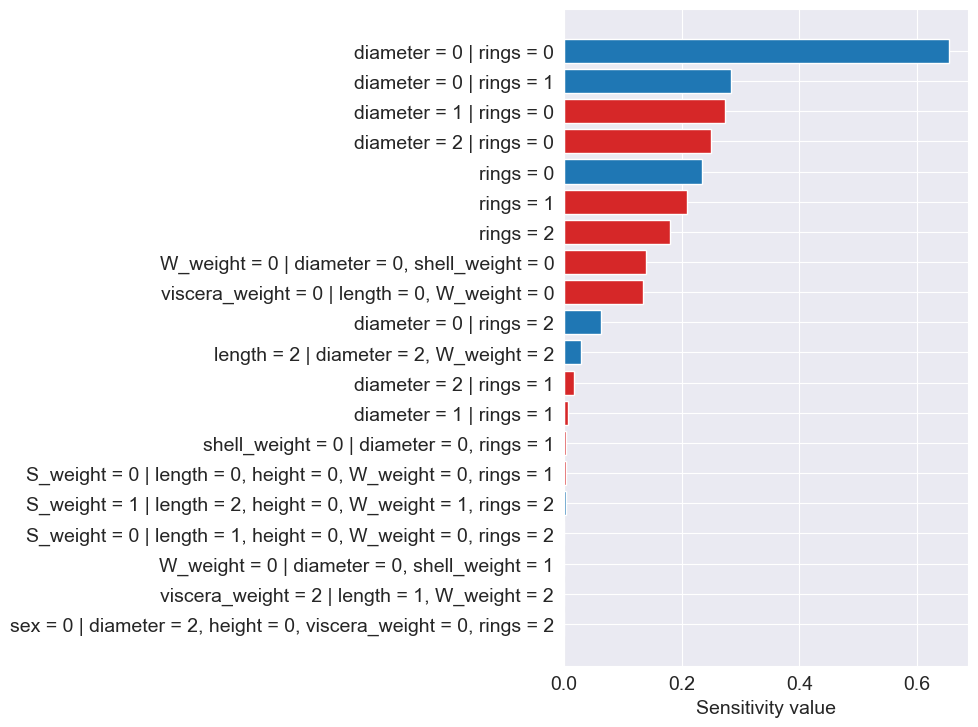

In [20]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'diameter': 0}, nbars=20)

<Figure size 640x480 with 0 Axes>

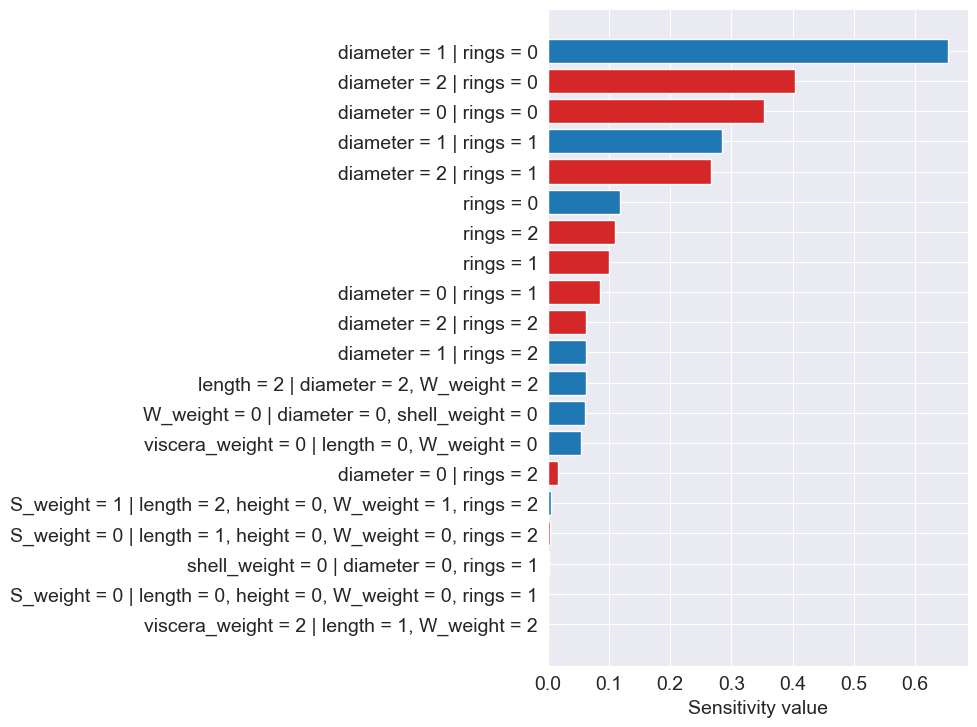

In [21]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'diameter': 1}, nbars=20)

<Figure size 640x480 with 0 Axes>

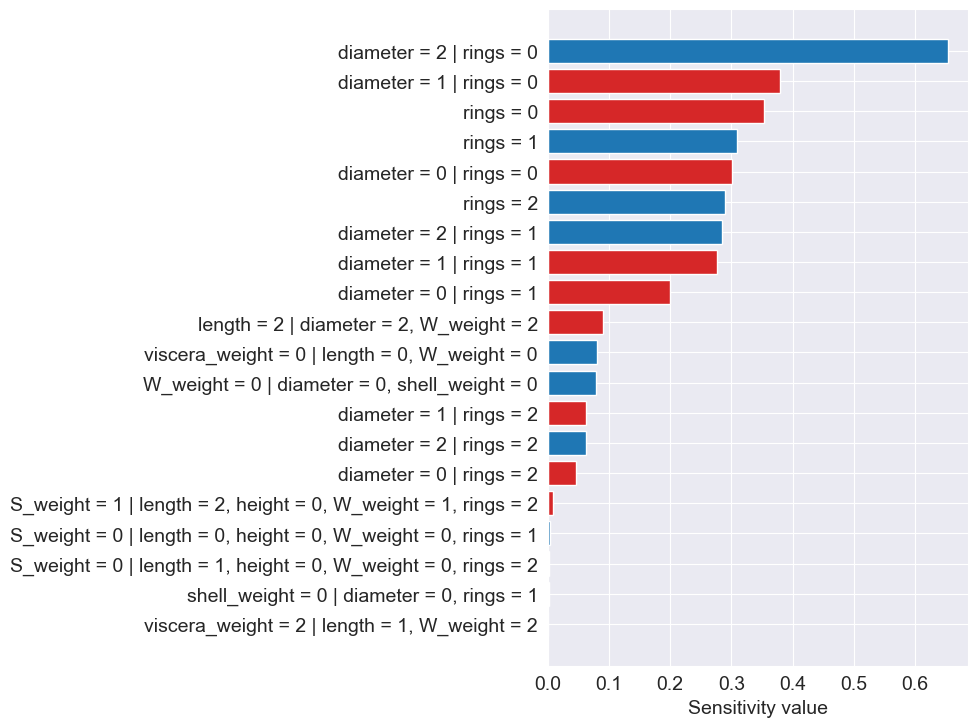

In [22]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'diameter': 2}, nbars=20)

<Figure size 640x480 with 0 Axes>

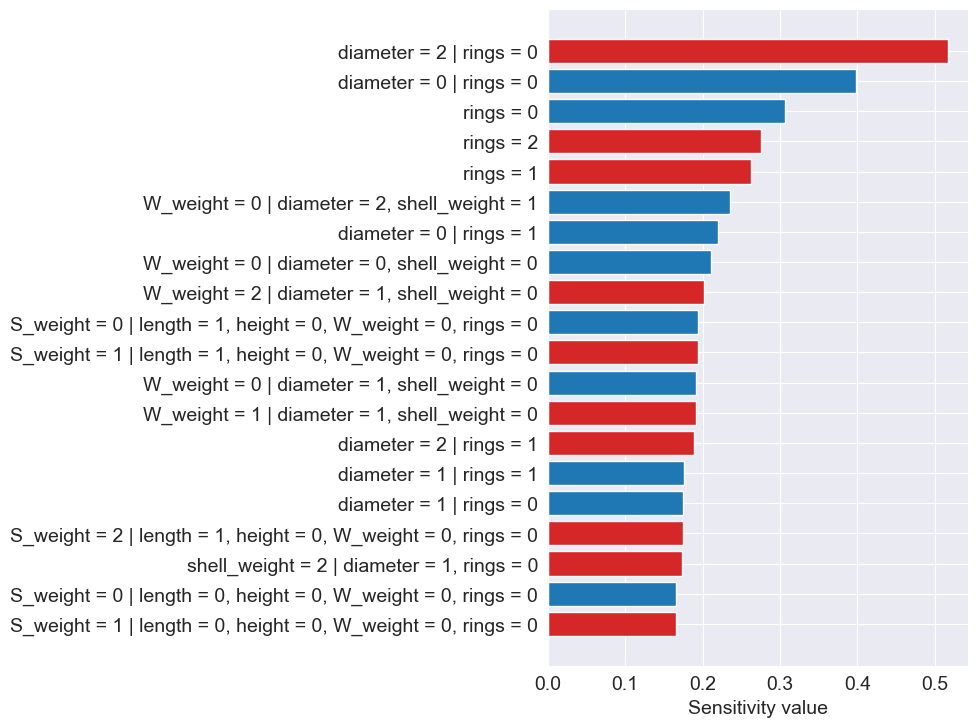

In [23]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'S_weight': 0}, nbars=20)

<Figure size 640x480 with 0 Axes>

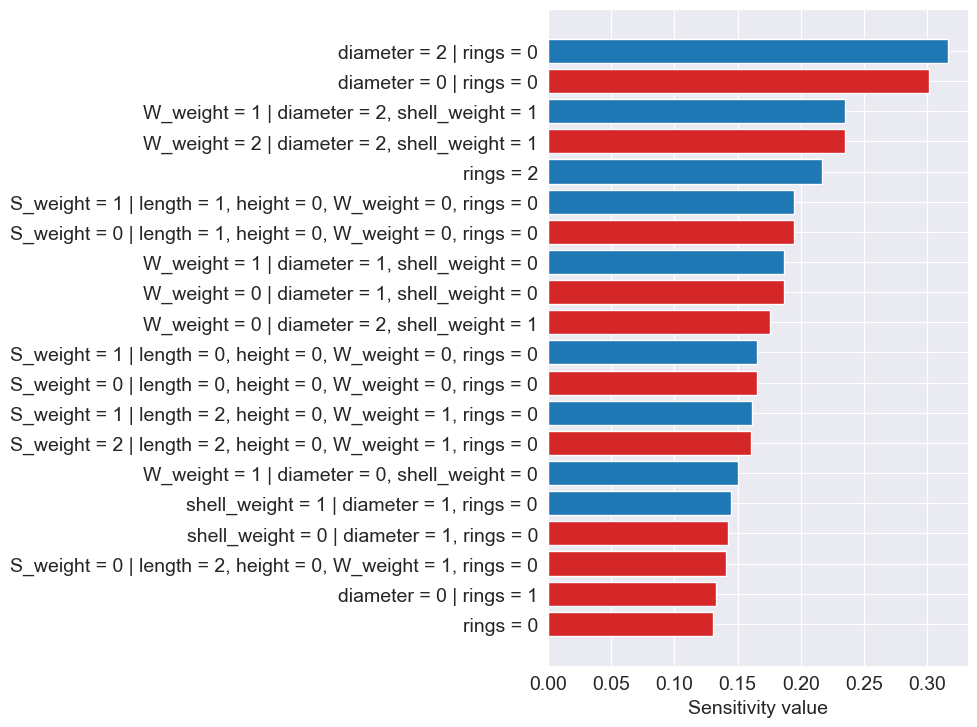

In [24]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'S_weight': 1}, nbars=20)

<Figure size 640x480 with 0 Axes>

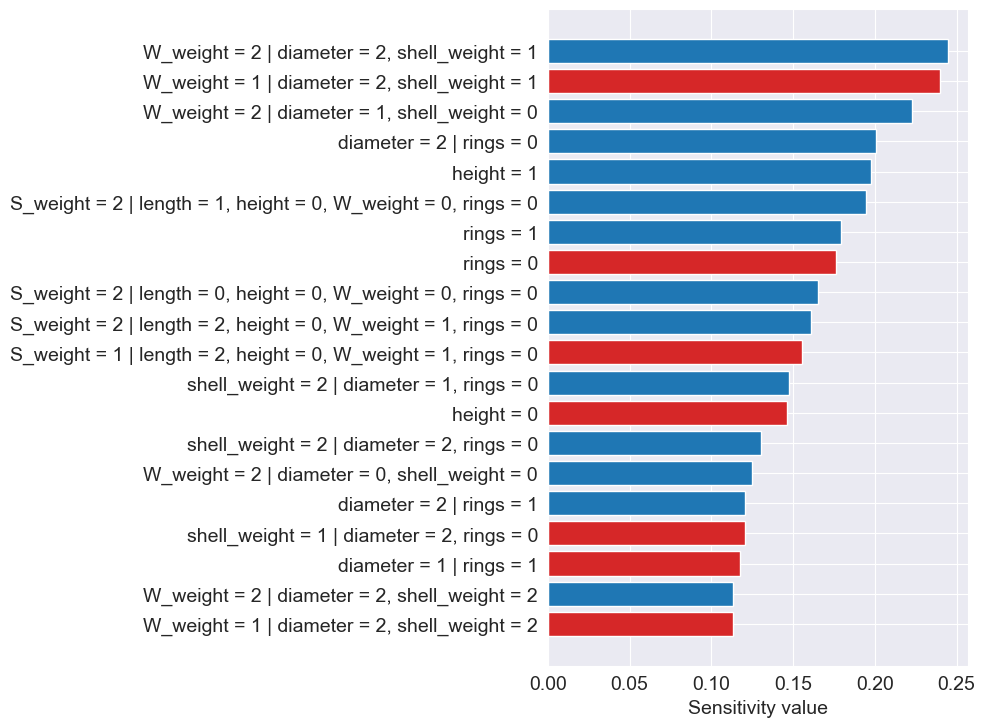

In [25]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'S_weight': 2}, nbars=20)

In [28]:
sens = yodo.yodo(pgmpy_bn, probability={'S_weight': 2})
sens

{('height',): {'cpt': tensor([9.9952e-01, 2.3941e-04, 2.3941e-04], dtype=torch.float64,
         names=('height',)),
  'derivative': tensor([-0.1464,  0.1978,  0.0950], dtype=torch.float64, names=('height',)),
  'sensitivity_value': tensor([0.1464, 0.1978, 0.0950], dtype=torch.float64, names=('height',)),
  'proximity': tensor([nan, nan, nan], dtype=torch.float64, names=('height',)),
  'second_derivative': tensor([0., -0., -0.], dtype=torch.float64, names=('height',)),
  'largest_first_derivative': tensor([0.1464, 0.1978, 0.0950], dtype=torch.float64)},
 ('rings',): {'cpt': tensor([0.6536, 0.2839, 0.0625], dtype=torch.float64, names=('rings',)),
  'derivative': tensor([-0.1762,  0.1793,  0.0589], dtype=torch.float64, names=('rings',)),
  'sensitivity_value': tensor([0.1762, 0.1793, 0.0589], dtype=torch.float64, names=('rings',)),
  'proximity': tensor([nan, nan, nan], dtype=torch.float64, names=('rings',)),
  'second_derivative': tensor([0., -0., -0.], dtype=torch.float64, names=('ring

In [34]:
for e in sens.keys():
    print((e, sens[e]["derivative"]))

(('height',), tensor([-0.1464,  0.1978,  0.0950], dtype=torch.float64, names=('height',)))
(('rings',), tensor([-0.1762,  0.1793,  0.0589], dtype=torch.float64, names=('rings',)))
(('diameter', 'rings'), tensor([[-0.0977, -0.0873, -0.0107],
        [-0.1125, -0.1174, -0.0182],
        [ 0.2008,  0.1208,  0.0182]], dtype=torch.float64,
       names=('diameter', 'rings')))
(('diameter', 'rings', 'shell_weight'), tensor([[[-5.0852e-09, -2.3805e-04,  0.0000e+00],
         [-8.9295e-03, -1.2778e-03, -2.6451e-04],
         [-1.9329e-02, -4.6467e-02, -9.5571e-03]],

        [[-1.4978e-11, -2.3805e-13,  0.0000e+00],
         [ 3.7152e-03,  5.3205e-04, -6.6545e-04],
         [-1.2068e-01, -1.0987e-01, -1.7517e-02]],

        [[ 4.3184e-02,  1.1507e-03,  0.0000e+00],
         [ 1.4752e-01,  3.2489e-02,  4.3057e-03],
         [ 1.3048e-01,  1.1162e-01,  1.7517e-02]]], dtype=torch.float64,
       names=('shell_weight', 'diameter', 'rings')))
(('W_weight', 'diameter', 'shell_weight'), tensor([[[-1.

In [36]:
vars = ('W_weight', 'diameter', 'shell_weight')
sens[vars]["derivative"]

tensor([[[-1.0354e-01, -2.9751e-04,  0.0000e+00],
         [-5.3795e-03, -2.1920e-03, -1.3255e-03],
         [-1.1146e-03, -5.9254e-02, -1.0343e-01]],

        [[ 7.9132e-03,  2.1118e-05,  0.0000e+00],
         [ 5.3795e-03,  1.0199e-03, -2.1932e-03],
         [-2.0003e-03, -2.3987e-01, -1.1340e-01]],

        [[ 1.2471e-01,  3.5936e-04,  0.0000e+00],
         [ 2.2257e-01,  8.7715e-02,  2.1932e-03],
         [ 3.7066e-03,  2.4472e-01,  1.1340e-01]]], dtype=torch.float64,
       names=('W_weight', 'diameter', 'shell_weight'))

In [42]:
torch.argmax(sens[vars]["derivative"].rename(None), dim=2)

tensor([[2, 2, 0],
        [0, 0, 0],
        [0, 0, 1]])

In [43]:
sensmax = torch.max(sens[vars]["derivative"].rename(None))
sensmax

tensor(0.2447, dtype=torch.float64)

In [44]:
sens[vars]["derivative"]==sensmax

tensor([[[False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False,  True, False]]],
       names=('W_weight', 'diameter', 'shell_weight'))

In [47]:
npsens = sens[vars]["derivative"].numpy()
npsens

array([[[-1.03544716e-01, -2.97512124e-04,  0.00000000e+00],
        [-5.37947913e-03, -2.19195978e-03, -1.32547509e-03],
        [-1.11456235e-03, -5.92543849e-02, -1.03428263e-01]],

       [[ 7.91318731e-03,  2.11177734e-05,  0.00000000e+00],
        [ 5.37947705e-03,  1.01990781e-03, -2.19316395e-03],
        [-2.00033073e-03, -2.39874814e-01, -1.13398755e-01]],

       [[ 1.24711027e-01,  3.59360123e-04,  0.00000000e+00],
        [ 2.22573097e-01,  8.77151290e-02,  2.19316395e-03],
        [ 3.70663064e-03,  2.44723575e-01,  1.13398755e-01]]])

In [48]:
np.argmax(npsens)

25

In [50]:
npmax = npsens.max()
npmax

0.24472357543288858

In [53]:
np.any(npsens == npmax, axis=2)

array([[False, False, False],
       [False, False, False],
       [False, False,  True]])

In [66]:
np.sort(npsens.flatten())

array([-2.39874814e-01, -1.13398755e-01, -1.03544716e-01, -1.03428263e-01,
       -5.92543849e-02, -5.37947913e-03, -2.19316395e-03, -2.19195978e-03,
       -2.00033073e-03, -1.32547509e-03, -1.11456235e-03, -2.97512124e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.11177734e-05,
        3.59360123e-04,  1.01990781e-03,  2.19316395e-03,  3.70663064e-03,
        5.37947705e-03,  7.91318731e-03,  8.77151290e-02,  1.13398755e-01,
        1.24711027e-01,  2.22573097e-01,  2.44723575e-01])

In [62]:
def where(A, m, dimlen=3):
    for i in range(dimlen):
        if np.any(A[i]==m):
            return i

In [63]:
def argmax_coords(A, ndims, dims_sizes):
    res = list()
    maxval = A.max()
    A_copy = copy.deepcopy(A)
    for dim in range(ndims):
        i = where(A_copy, maxval, dims_sizes[dim])
        res.append(i)
        A_copy = A_copy[i]
    return (res, maxval)

In [56]:
argmax = list()
B = copy.deepcopy(npsens)
for dim in range(3):
    i = where(B, npmax)
    argmax.append(i)
    B = B[i]
argmax

[2, 2, 1]

In [64]:
argmax_coords(npsens, 3, npsens.shape)

([2, 2, 1], 0.24472357543288858)

In [58]:
np.max(npsens,

(3, 3, 3)

In [70]:
def find_top_sensitivity_values(info):
    res = dict()
    for vars, vals in info.items():
        a = info[vars]["derivative"].numpy()
        ndims = len(a.shape)
        res[vars] = argmax_coords(a, ndims, a.shape)
    return res

In [71]:
find_top_sensitivity_values(sens)

{('height',): ([1], 0.19778954405066054),
 ('rings',): ([1], 0.1793078183798989),
 ('diameter', 'rings'): ([2, 0], 0.2008261810472303),
 ('diameter', 'rings', 'shell_weight'): ([2, 1, 0], 0.14752306151042108),
 ('W_weight', 'diameter', 'shell_weight'): ([2, 2, 1], 0.24472357543288858),
 ('W_weight', 'diameter', 'length'): ([2, 2, 1], 0.030032671365512312),
 ('W_weight', 'length', 'viscera_weight'): ([0, 0, 0], 0.02982575849435729),
 ('diameter', 'height', 'rings', 'sex', 'viscera_weight'): ([0, 2, 0, 0, 2],
  9.21333500937138e-05),
 ('S_weight', 'W_weight', 'height', 'length', 'rings'): ([2, 1, 0, 0, 0],
  0.194717547486481)}